# Use Deep Learning to Clone Driving Behavior

## Submission criterias

Note: Here is checklist ** created for myself ** to verify if I met submission criterias. 

### Quality of Code
- Is the code functional?
    - [X] The model provided can be used to successfully operate the simulation. However my model was able to drive the car only for 30-45 sec. I definitely need to collect more training data.    
- Is the code usable and readable?
    - [X] The code in model.py uses a Python generator to generate data for training rather than storing the training data in memory. 
    - [X] The model.py code is clearly organized and comments are included where needed.
    
### Model Architecture and Training Strategy
- Has an appropriate model architecture been employed for the task?
    * [X] The neural network uses convolution layers with appropriate filter sizes. 
    * [X] Layers exist to introduce nonlinearity into the model. 
    * [X] The data is normalized in the model.
    
- Has an attempt been made to reduce overfitting of the model?
    - [X] Train/validation/test splits have been used, and the model was updated with dropout layers  to reduce overfitting. However it did not improved the model accuracy. 
- Have the model parameters been tuned appropriately?
    -  [X] An Adam optimizer is used.
- Is the training data chosen appropriately?
    - [X] Not completed. Collecting data on my own was extremely difficult perhaps because I was limited by use of touchpad to control the simulator. I tried many times to collect the data withoud any success. However this gave me a chance to understand how important is the process of collecting the training data. So, I've used only the data provided in the project. I definitely need more training data to induce the desired behavior in the simulation (i.e. keeping the car on the track).
    
### Architecture and Training Documentation
- Is the solution design documented?
    - [X] The README and Jupyter notebook are created to discusses the approach taken for deriving and designing a model architecture fit for solving the given problem.
- Is the model architecture documented?
    - [X] I have choosen an original Nvidia model without any changes. Visualizations emphasizing particular qualities of the architecture are provided.
- Is the creation of the training dataset and training process documented?
    - [X] I did augmentation extensively since the training dataset is small and contains huge number of repeated zero values. Augmentation helps extract as much information from data as possible. I generated additional data using the several data augmentation techniques. As a refference I have used [post 1](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.vbfk0tp2p) and [post 2](https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.xrn3giarp)
    - [X] I trained the model using a keras generator that took in data frame with paths to image and returned a specified number of training image and steering angles. I programmed the generator to drop training samples with smaller angles with a tunable probability input. This was done to avoid bias for going straight.
    
### Simulation
- Is the car able to navigate correctly on test data?
    - [_] Not completed. My model was able to drive the car only for 30-45 sec onthe track 1. I have underestimated the difficulty of the project and was not able to collect more training data. 


## Project files
- model.py - The script used to create and train the model.
- drive.py - The script to drive the car. 
- model.json - The model architecture.
- model.h5 - The model weights.
- README.md  - explains the structure of network and training approach.

## Solution
 
### Collecting data.
Collecting data on my own was very difficult considering that I was limited by use of keyboard to control the simulator. I tried many times to collect the data withoud a success. But this gave me a chance to understand how important is the process of collecting the training data. So, I've started with the data provided in the project. I've downloaded and unziped the csv file and images into the data directory.

### Loading data

In [1]:
### Importing packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math
from scipy.misc import imread

# Loading data
csv_path = 'data/driving_log.csv'
data_files_s = pd.read_csv(csv_path, 
    header = 0,                       
    names=['center','left','right','steer','throttle','break','speed'],
    index_col = False)
data_files_s['direction'] = pd.Series('s', index=data_files_s.index)
rev_steer_s = np.array(data_files_s.steer)

print('number of data files: ', len(data_files_s))

number of data files:  8036


### Understanding data: data stats + plotting data distribution
As with all deep learning problems, the first step is to understand the data we are working with. The most important for us is the steering angle. So, let's analyse it.

### Angle over time 

/home/alexb/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


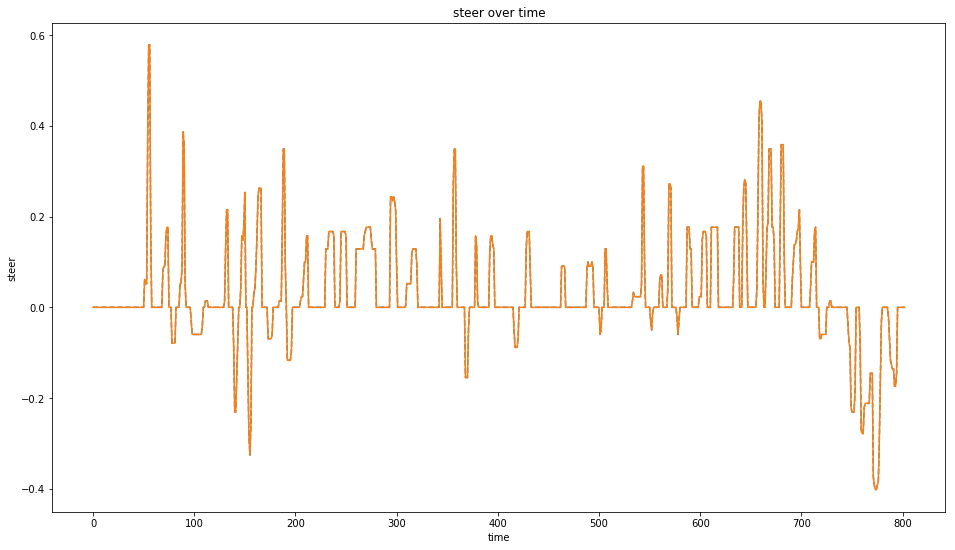

In [2]:
# Putionlot angle over time distrib
FRAMES_PER_SECOND = 10
len_plt = len(data_files_s) / FRAMES_PER_SECOND 

def plot_x_over_time(x, length, label):
    rev = np.array(x,dtype=np.float32)
    t_s = np.arange(len(rev))
    x_s = np.array(x)
    y_s = rev
    sm_s = rev
    plt.rcParams["figure.figsize"]= [16, 9]
    plt.plot(t_s[0:len_plt],x_s[0:len_plt],'--',t_s[0:len_plt],y_s[0:len_plt]);
    plt.title(label +  ' over time')
    plt.xlabel('time')
    plt.ylabel(label)
    plt.show()
    
plot_x_over_time(data_files_s.steer, len_plt, 'steer')
# plot_x_over_time(data_files_s.speed, len_plt, 'speed')
# plot_x_over_time(data_files_s.throttle, len_plt, 'throttle')
# plot_x_over_time(data_files_s['break'], len_plt, 'breaks')


### Angle distribution 

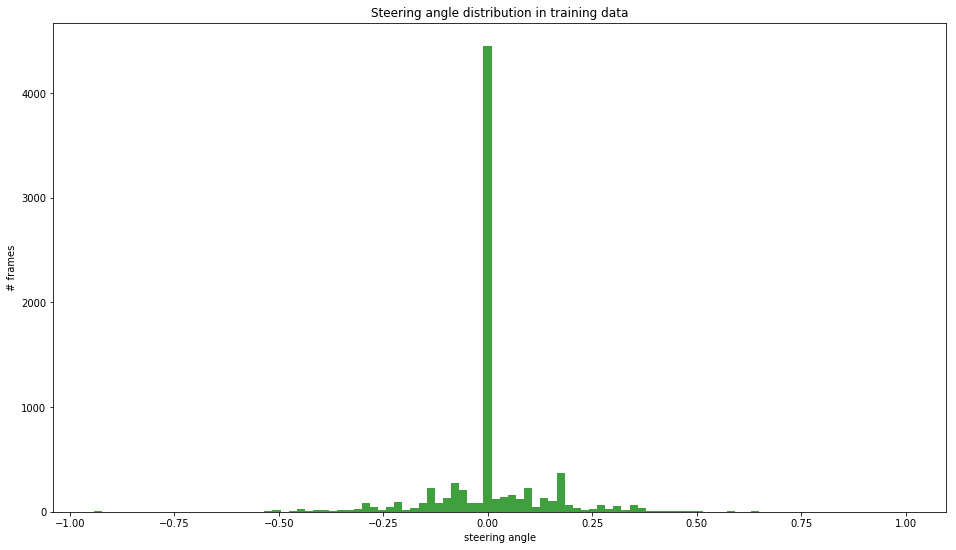

In [3]:
def visualize_steering_distribution(train_data):
    """
    Visualize the training ground truth distribution "as provided"
    :param train_data: list of udacity training data
    :return:
    """
    train_steering = np.float32(np.array(train_data.steer))
    plt.title('Steering angle distribution in training data')
    plt.hist(train_steering, 100, normed=0, facecolor='green', alpha=0.75)
    plt.ylabel('# frames'), plt.xlabel('steering angle')
    plt.show()
    
visualize_steering_distribution(data_files_s)    

We see that the dataset holds large number of zeros and very very few of all other data. This is definitely going to bias our model towards predicting 0s, if we go ahead as it is. So we really need to think about augmentation.
Augmentation helps us extract as much information from data as possible. We will generate additional data using the several data augmentation techniques.
** Disclaimer: Big part of described below data augmentation techniques has been adapted from [this post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.717xcwyla).**


### Reading images


In [4]:
MODEL_IMG_WIDTH = 200
MODEL_IMG_HEIGHT = 66

def read_image(file):
    # Readimage from file
    image = imread('data/' + file)
    return image

def crop_resize_image(image,new_size_col=MODEL_IMG_WIDTH,new_size_row=MODEL_IMG_HEIGHT):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col, new_size_row), interpolation=cv2.INTER_AREA)  
    return image


train image shape (160, 320, 3)
cropped image shape (66, 200, 3)


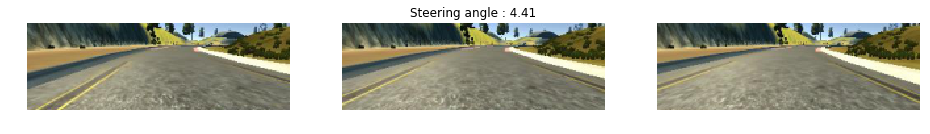

In [5]:
rev_steer_s = np.array(data_files_s.steer,dtype=np.float32)
steer_sm_s = rev_steer_s
data_files_s['steer_sm'] = pd.Series(steer_sm_s, index=data_files_s.index)

image_c = read_image(data_files_s['center'][0].strip())
TRAIN_IMG_HEIGHT, TRAIN_IMG_WIDTH, TRAIN_IMG_DEPTH = image_c.shape
print('train image shape',  image_c.shape)

croped_image = crop_resize_image(image_c)
print('cropped image shape',  croped_image.shape)

# Test out cropping out region of interest
ind_num = np.random.randint(len(data_files_s))

image_c = crop_resize_image(read_image(data_files_s['center'][ind_num].strip()))
image_r = crop_resize_image(read_image(data_files_s['right'][ind_num].strip()))
image_l = crop_resize_image(read_image(data_files_s['left'][ind_num].strip()))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

We see that original images are has dimension 320 by 160 but for our model we need a different size 200 by 66. OUr model will learn from the middle part of the image, so we'll cut the top and the bottom of the original image.

### Shifting images
I randomly shifted the camera images to simulate the effect of car being at different positions on the lane, and added an offset corresponding to the shift to the steering angle. *** A better solution could be generating a wide angle and do several crops with a steering offset ** 

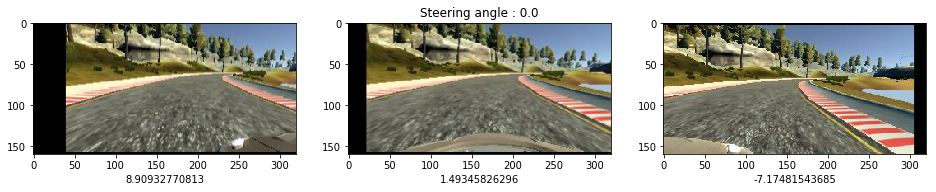

In [6]:
def trans_image(image, steer, trans_range):
    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x/trans_range * 2 *.2
    tr_y = 10 * np.random.uniform() - 10 / 2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (320, 160))
    #print(steer, steer_ang,tr_x)
    return image_tr, steer_ang, tr_x

# Test translation
ind_num = np.random.randint(len(data_files_s))
angle = rev_steer_s[ind_num]
#print(angle, ind_num)
image_c, a_c, t_c = trans_image(read_image(data_files_s['center'][ind_num].strip()), angle, 150)
image_r, a_r, t_r = trans_image(read_image(data_files_s['right'][ind_num].strip()), angle -.25, 150)
image_l, a_l, t_l = trans_image(read_image(data_files_s['left'][ind_num].strip()), angle + .25, 150 )
plt.figure()
plt.subplot(1,3,1)
plt.xlabel(a_l * 25)
plt.imshow(image_l);
#plt.axis('off')
plt.subplot(1,3,2)
plt.xlabel(a_c * 25)
plt.imshow(image_c);
#plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.xlabel(a_r * 25)
plt.imshow(image_r);
#plt.axis('off');

### Brightness adjustment

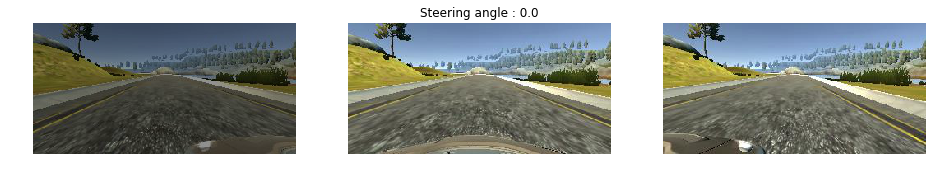

In [7]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .5 + np.random.uniform()
    if (random_bright > 1):
           random_bright = 1    
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

ind_num = np.random.randint(len(data_files_s))

image_c = augment_brightness(read_image(data_files_s['center'][ind_num].strip()))
image_r = augment_brightness(read_image(data_files_s['right'][ind_num].strip()))
image_l = augment_brightness(read_image(data_files_s['left'][ind_num].strip()))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

### Crop out region of interest and resize

train image shape (160, 320, 3)
cropped image shape (66, 200, 3)


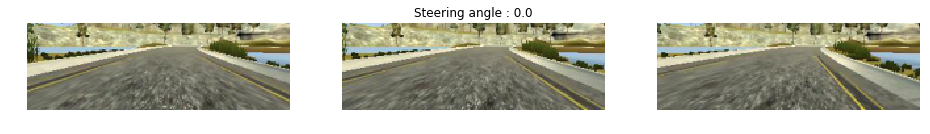

In [8]:
# Test out cropping out region of interest 
ind_num = np.random.randint(len(data_files_s))

image_c = read_image(data_files_s['center'][ind_num].strip())
rows, cols, channels = image_c.shape
print('train image shape',  image_c.shape)
croped_image = crop_resize_image(image_c)
print('cropped image shape',  croped_image.shape)

image_c = crop_resize_image(read_image(data_files_s['center'][ind_num].strip()))
image_r = crop_resize_image(read_image(data_files_s['right'][ind_num].strip()))
image_l = crop_resize_image(read_image(data_files_s['left'][ind_num].strip()))

plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(rev_steer_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r);
plt.axis('off');

### Flipping images 
One easy way to get more data is to just flip the image around the horizontal axis and flip the sign on the angle as well. We instantly get twice the data and we don’t inadvertently bias the model towards any one direction.

### Test augmentation 

In [9]:

def preprocess_image_file_train(line_data):
    # Preprocessing training files and augmenting
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
        
    y_steer = line_data['steer_sm'][0] + shift_ang
    image = imread('data/' + path_file)
    
    image, y_steer, tr_x = trans_image(image, y_steer, 150)
    
    image = augment_brightness(image)
    
    image = crop_resize_image(image)
    image = np.array(image)
    
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer

    return image, y_steer


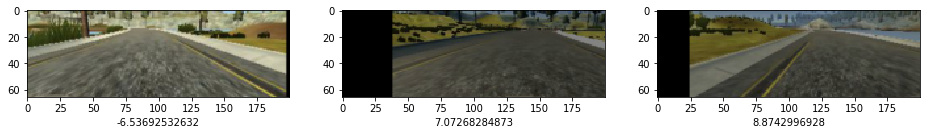

In [10]:
# Test augmentation
c = np.random.randint(len(data_files_s))
l_c = data_files_s.iloc[[c]].reset_index()
r = np.random.randint(len(data_files_s))
l_r = data_files_s.iloc[[r]].reset_index()
l = np.random.randint(len(data_files_s))
l_l = data_files_s.iloc[[l]].reset_index()

image_c, a_c = preprocess_image_file_train(l_c)
image_r, a_r = preprocess_image_file_train(l_r)
image_l, a_l = preprocess_image_file_train(l_l)

plt.figure()
plt.subplot(1,3,1)
plt.xlabel(a_l * 25)
plt.imshow(image_l);
plt.subplot(1,3,2)
plt.xlabel(a_c * 25)
plt.imshow(image_c);
plt.subplot(1,3,3)
plt.xlabel(a_r * 25)
plt.imshow(image_r);

## Model architecture

I decided to use unmodified [NVIDIA model](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) 
<img src="https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture.png" width="400">

<p><center>NVIDIA model architecture, taken from [End to end learning for self-driving cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)</center>

I did not use dropouts or maxpooling in our architecture to remain true to NVIDIA model. 

I used exponential leaky units (ELU) for activation functions, because ELUs have smoother derivatives at zero, and hence are expected to be slighly better for predicted continuous values. I tested the model with rectified linear units (ReLU) too, and noticed minimal performance difference between the two networks.

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

def nvidia_model(summary=False):
    init = 'he_normal'
    model = Sequential()
    # TODO:  checkif we can do mean subtraction
    model.add(Lambda(lambda z: z / 127.5 - 1., input_shape=[MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH, 3]))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), init=init))
    model.add(ELU())
#    model.add(Dropout(0.2))
    model.add(Flatten())
#    model.add(Dropout(0.2))
    model.add(Dense(1164, init=init))
    model.add(ELU())
#    model.add(Dropout(0.5))
    model.add(Dense(100, init=init))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(50, init=init))
    model.add(ELU())
    model.add(Dense(10, init=init))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Dense(1, init=init))
    model.add(ELU())

    if summary:
        model.summary()
    return model


In [14]:
model = nvidia_model(True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_11 (ELU)                     (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       elu_11[0][0]                     
___________________________________________________________________________________________

### Keras generator and subsampling
Since most of the time the car is driving along straight line, it is highly likely that the car is biased toward going straight. To remove this bias, we need to subsampled data to drop small angles with probabilities. The drop probability will start high in the initial part, and will be reduced as training epochs progressed.

In [15]:
def generate_train_from_PD_batch(data, batch_size):
    ## Generator for keras training, with subsampling
    batch_images = np.zeros((batch_size, MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i in range(batch_size):
            rnd = np.random.randint(len(data))
            line_data = data.iloc[[rnd]].reset_index()
            keep_pr = 0
            while keep_pr == 0:
                img, angle = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(angle) < .15:
                    pr_val = np.random.uniform()
                    if pr_val > pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            batch_images[i] = img
            batch_steering[i] = angle
        yield batch_images, batch_steering


### Optimizer 
I have choosen Adam optimizer with a learning rate of 1e-4. This was empirically noted as I was fine tuning an existing model.


In [16]:
from keras.optimizers import Adam
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model 
model.compile(optimizer=adam, loss='mse')

In [17]:
def preprocess_image_file_predict(line_data):
    # Preprocessing Prediction files and augmenting
    path_file = line_data['center'][0].strip()
    image = imread('data/' + path_file)
    image = crop_resize_image(image)
    image = np.array(image)
    return image

def generate_valid_from_PD(data):
    # Validation generator
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer_sm'][0]
            y = np.array([[y]])
            yield x, y

def save_model(fileModelJSON, fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    
valid_s_generator = generate_valid_from_PD(data_files_s)

### Bias
I started with a bias of 1.0 (allow all angles) and slowly as the epochs continue, reduce the bias, thereby dropping low angles progressively.

## Training loop
I trained the model using a keras generator that took in data frame with paths to image and returned a specified number of training image and steering angles. I programmed the generator to drop training samples with smaller angles with a tunable probability input. This was done to avoid bias for going straight. 

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import cv2
import math
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations
from pathlib import Path
import json

from scipy.misc import imread

val_size = len(data_files_s)
pr_threshold = 1
batch_size = 256
i_best = 0
val_best = 1000

for i in range(10):
    train_r_generator = generate_train_from_PD_batch(data_files_s, batch_size)
    train_r_generator
    nb_vals = np.round(len(data_files_s) / val_size) - 1
    history = model.fit_generator(train_r_generator, samples_per_epoch=20224, nb_epoch=1, validation_data=valid_s_generator, nb_val_samples=val_size)
    fileModelJSON = 'model_' + str(i) + '.json'
    fileWeights = 'model_' + str(i) + '.h5'
    save_model(fileModelJSON, fileWeights)
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i
        val_best = val_loss
        fileModelJSON = 'model_top.json'
        fileWeights = 'model_top.h5'
        save_model(fileModelJSON, fileWeights)
        pr_threshold = 1 / (i + 1)

print('Best validation score: ' + str(np.round(val_best,4)))

Epoch 1/1
20224/20224 [==============================] - 158s - loss: 0.5226 - val_loss: 0.0172

### Reflection

This was the most difficut project I did so far with Udacity Self Driving Car Program. Besides collection the data and verifying the model there were lots of challenging tasks. Although all the image augmentation and tweaks seem reasonable, I am not sure if how important they are.